## Perform standard imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


import matplotlib.pyplot as plt
import seaborn as sns

## Reading Dataset And initial weight

In [2]:
training_data= pd.read_excel('./Computer_Assignment_4_Data.xls',sheet_name='Training Set',header=1)
test_data= pd.read_excel('./Computer_Assignment_4_Data.xls',sheet_name='Testing Set',header=1)

In [3]:
X_train= training_data.iloc[:,1:3]
y_train= training_data.iloc[:,3:]

In [4]:
X_test= test_data.iloc[:,1:3]
y_test= test_data.iloc[:,0]

In [5]:
train_target= training_data.iloc[:,3:]
test_target= training_data.iloc[:,3:]

In [6]:
training_data.sample(2,random_state=32)

,Class #,x1,x2,Target 1,Target 2
632,1,0.313919,0.446901,0.95,0.05
687,2,0.613985,0.400960,0.05,0.95


In [7]:
test_data.sample(2,random_state=32)

,Class #,x1,x2
632,2,0.591131,0.489398
687,2,0.573624,0.548367


import weights manually

In [8]:
import numpy as np

# Input to Hidden Weights (excluding bias)
input_to_hidden_weights = np.array([
    [0.248493, 0.169035],   
    [-0.397141, 0.371143],  
    [0.027034, -0.173352],  
    [-0.115785, -0.408767]  
])

# Bias weights for Hidden Layer
# Shape: (# of hidden neurons,)
hidden_layer_biases = np.array([
    -0.357132,  
    0.360178,   
    -0.474102,  
    -0.048102   
])

# Hidden to Output Weights (excluding bias)
hidden_to_output_weights = np.array([
    [0.012515, 0.448336, 0.091863, 0.143707],  
    [-0.065186, 0.306281, -0.059266, -0.045253] 
])

# Bias weights for Output Layer
# Shape: (# of output neurons,)
output_layer_biases = np.array([
    -0.191953,  
    0.290301   
    
])

lr= .2
epochs=500

print(f'''Input to Hidden Weights:\n\n{input_to_hidden_weights}
       \n\nHidden to Output Weights:\n\n{hidden_to_output_weights}
        \nLearning Rate: {lr}
        \nEpoch: {epochs}''')


Input to Hidden Weights:

[[ 0.248493  0.169035]
 [-0.397141  0.371143]
 [ 0.027034 -0.173352]
 [-0.115785 -0.408767]]
       

Hidden to Output Weights:

[[ 0.012515  0.448336  0.091863  0.143707]
 [-0.065186  0.306281 -0.059266 -0.045253]]
        
Learning Rate: 0.2
        
Epoch: 500


In [9]:
weights = [input_to_hidden_weights, hidden_to_output_weights]
biases= [hidden_layer_biases,output_layer_biases]

In [10]:
X = X_train.T.to_numpy()
y= y_train.T.to_numpy()

## Impelementing MLP

In [11]:
class MLP:
    def __init__(self, weights, biases, y_true):
        # Initialize the MLP with weights, biases, and true labels.
        self.weights = weights
        self.biases = biases

        # Initialize loss and gradients.
        self.loss = []
        self.dw = [np.zeros_like(layer) for layer in weights]  # Gradients for weights
        self.db = [np.zeros_like(bias) for bias in biases]      # Gradients for biases

        self.y_true = y_true
        self.m = y_true.shape[1]  # Number of samples

        # Intermediate values for backpropagation
        self.dz = [[] for _ in range(len(self.weights))]
        self.da = [[] for _ in range(len(self.weights))]

    def forward(self, X):
        # Perform forward propagation.
        self.a = [X]  # Activations for each layer
        self.z = [X]  # Weighted sums for each layer

        for i in range(len(self.weights)):
            # Compute weighted sum and activation for each layer
            self.z.append(self.weights[i] @ self.a[i] + self.biases[i].reshape(-1, 1))
            self.a.append(self.sigmoid(self.z[i + 1]))

        self.y_pred = self.a[-1]  # Output of the final layer
        return self.y_pred

    def sigmoid(self, z):
        # Activation function: Sigmoid
        return 1 / (1 + np.exp(-z))

    def derevtives(self, z):
        # Derivative of the sigmoid function
        return z * (1 - z)

    def criterion(self):
        # Compute binary cross-entropy loss.
        result = -1 * (self.y_true * np.log2(self.y_pred) + (1 - self.y_true) * np.log2(1 - self.y_pred))
        self.loss = result.sum(axis=1) / self.m
        return self.loss

    def backward(self):
        # Perform backpropagation to compute gradients.
        for i in range(len(self.weights), 0, -1):
            j = i - 1
            if i == len(self.weights):
                # For the output layer
                self.dz[j] = self.y_pred - self.y_true
                self.dw[j] = (1 / self.m) * (self.dz[j] @ self.a[j].T)
                self.db[j] = (1 / self.m) * np.sum(self.dz[j], axis=1, keepdims=True)
            else:
                # For hidden layers
                self.da[j] = self.weights[j + 1].T @ self.dz[j + 1]
                self.dz[j] = self.da[j] * self.derevtives(self.z[j + 1])
                self.dw[j] = (1 / self.m) * (self.dz[j] @ self.a[j].T)
                self.db[j] = (1 / self.m) * np.sum(self.dz[j], axis=1, keepdims=True)

    def step(self, alpha):
        # Update weights and biases using gradients.
        for i in range(len(self.weights)):
            self.weights[i] -= alpha * self.dw[i]
            self.biases[i] -= alpha * self.db[i].reshape(-1)

    def zero_grad(self):
        # Reset intermediate values and gradients.
        self.z = [X]
        self.a = [X]
        self.dw = [np.zeros_like(layer) for layer in self.weights]
        self.db = [np.zeros_like(bias) for bias in self.biases]


## Running MLP

In [12]:
mlp = MLP( weights=weights, biases=biases, y_true=y)

In [13]:
for epoch in range(500):
    y_pred= mlp.forward(X)
    loss= mlp.criterion()
    mlp.backward()
    mlp.step(alpha=lr)
    mlp.zero_grad()


In [14]:
y_pred= np.where(y_pred[0] > y_pred[1],1,2)
y_true = training_data['Class #'].to_numpy()

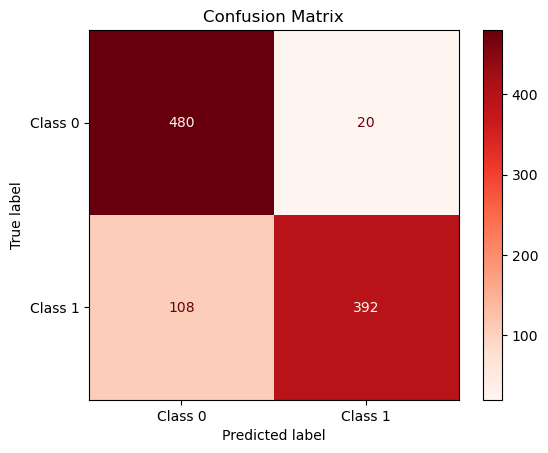

In [15]:
confusion_matrix_values = confusion_matrix(y_true, y_pred)
class_labels = [f"Class {index}" for index in range(len(confusion_matrix_values))]

# Create and plot the confusion matrix display
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix_values,
    display_labels=class_labels
).plot(cmap=plt.cm.Reds)

# Add a title and show the plot
plt.title("Confusion Matrix")
plt.show()

## Run model on Test data and confusion matrix

In [16]:
X_test= test_data.iloc[:,1:].T.to_numpy()
y_test_true= test_data['Class #'].to_numpy()

In [17]:
y_test_pred= mlp.forward(X_test)

In [18]:
y_test_pred= np.where(y_test_pred[0] > y_test_pred[1],1,2)
y_test_true = test_data['Class #'].to_numpy()

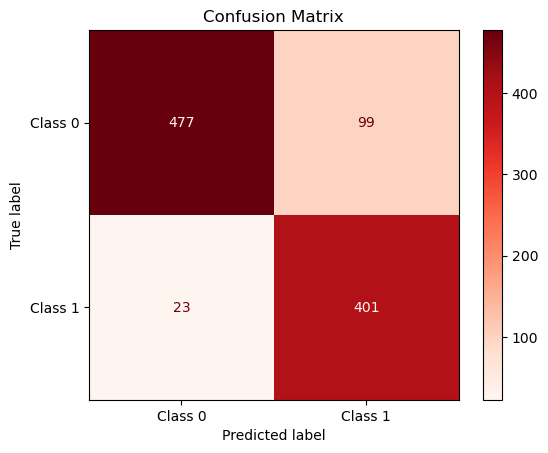

In [19]:
confusion_matrix_values = confusion_matrix(y_test_pred, y_test_true)
class_labels = [f"Class {index}" for index in range(len(confusion_matrix_values))]

# Create and plot the confusion matrix display
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix_values,
    display_labels=class_labels
).plot(cmap=plt.cm.Reds)

# Add a title and show the plot
plt.title("Confusion Matrix")
plt.show()

## Report Missclassified samples

In [20]:
missclassified= np.where(y_test_pred != y_test_true)

In [21]:
missclassified_data= test_data[test_data.index.isin(missclassified[0])].rename(columns={'Class #':'y_true'})
missclassified_data['y_pred']= missclassified_data.apply(lambda x: 2 if x.y_true==1 else 1,axis=1)
missclassified_data= pd.concat((missclassified_data.iloc[:,1:3],missclassified_data.iloc[:,:1],missclassified_data.iloc[:,3:]),axis=1)

In [22]:
missclassified_data.head(50)

,x1,x2,y_true,y_pred
15,0.646909,0.359998,1,2
24,0.512555,0.389556,1,2
36,0.600282,0.534144,1,2
55,0.495441,0.284731,1,2
65,0.566537,0.402272,1,2
93,0.565492,0.461995,1,2
122,0.498905,0.373127,1,2
147,0.553822,0.423154,1,2
150,0.515611,0.403821,1,2
210,0.542127,0.417930,1,2


## Report Wreights and Biases

In [23]:
weights_data= pd.read_excel('./Computer_Assignment_4_Data.xls',sheet_name='Initial Weights',header=1)

In [24]:
weights_data.iloc[10:14,2]=mlp.biases[0]
weights_data.iloc[10:12,6]=mlp.biases[1]

In [25]:
weights_data.iloc[2:10,2]=mlp.weights[0].T.flatten()
weights_data.iloc[2:10,6]=mlp.weights[1].T.flatten()

In [26]:
with pd.ExcelWriter('Report.xlsx', engine='openpyxl') as writer:
    missclassified_data.to_excel(writer, sheet_name='missclassified_data', index=False)
    weights_data.to_excel(writer, sheet_name='Weights', index=False)
